# NYC Yellow Taxi Analysis

![](./images/image1.jpg)

**Introduction:**\
The New York City Taxi and Limousine Commission (TLC), created in 1971, is the agency responsible for licensing and regulating New York City’s medallion (yellow) taxicabs, for-hire vehicles (community-based liveries, black cars and luxury limousines), commuter vans, and paratransit vehicles. TLC has released a staggeringly detailed historical dataset covering over 1 billion individual taxi trips in the city starting from January 2009 through December 2020. Taken as a whole, the detailed trip-level data is more than just a vast list of taxi pickup and drop off coordinates: it’s a story of how New Yorkers move around the city. How bad is the rush hour traffic? What are the hotspots for pickup and dropoff location? How much tip do drivers get? The dataset helps in addressing all of these questions and many more. 
 
This dataset is of high value for fetching useful insights that may help policy makers and city administration to make effective policies towards curbing traffic and reducing the number of disputes in public transport. And hence, The purpose of our analysis is to extract useful insights so that the solutions are developed from both, the customer’s perspective as well driver’s perspective.

Data Source:- https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

### Data Dictionary

|      Column Name     |                                              Column Description                                              |
|:--------------------:|:------------------------------------------------------------------------------------------------------------:|
| tpep_pickup_datetime | Holds the pickup datetime information for a trip                                                             |
| tpep_pickup_datetime | Holds the dropoff datetime information for a trip                                                            |
| passenger_count      | Number of passengers for a trip                                                                              |
| trip_distance        | Distance of trip done in miles                                                                               |
| PULocationID         | TLC Taxi Zone in which the taximeter was engaged                                                             |
| DOLocationID         | TLC Taxi Zone in which the taximeter was disengaged                                                          |
| payment_type         | Type of payment in number 1 = Credit card, 2 = Cash, 3 = No charge, 4 = Dispute 5 = Unknown, 6 = Voided trip |
| tip_amount           | Tip amount for a trip (Cash tips are not included)                                                           |
| total_amount         | Total amount for a trip (without tips)                                                                       |
| weekday              | Weekday for initiated  trip                                                                                  |
| pickup_hour          | Pickup hour for a trip                                                                                       |
| dropoff_hour         | Drop off hour for a trip                                                                                     |


### 1. Importing neccessary libraries

In [1]:
# Data Wrangling
import numpy as np
import pandas as pd
import sqlite3
import sqlalchemy as db
from sqlalchemy import *
from sqlalchemy.ext.compiler import compiles

import urllib.request
import zipfile
import random
import itertools
import math

# Data Visualization
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import matplotlib

import seaborn as sns
palette = sns.color_palette('Paired', 10)

# Removing Warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Getting and storing the data
- The data I'll be using for this analysis is: Yellow taxi trips data for the year 2019.
- Give the huge amount of the data, It is wise to a database management system. Here I'll be using **SQLite** to store the data. **SQLalechemy** is an ORM used to interact with the DB.
- The database file created is called **'nyc_db.db'**

In [2]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///nyc_db.db')

**Note:** This chunk of the code is to download the data. I've already provided the files in the directory called data. Run only if needed.

In [8]:
# Download the Trip Record Data
# for month in range(1,13):
#     urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
#                                "yellow_tripdata_2019-{0:0=2d}.csv".format(month), 
#                                "nyc.2019-{0:0=2d}.csv".format(month))

# Download the location Data
# urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")
# with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
#     zip_ref.extractall("./shape")

**Note:** The next part of the code adds the data into the database. Make sure that the code is executed only once. Otherwise, duplicate data will be added.

In [3]:
j, chunksize = 1, 400000
for month in range(1,7):
    fp = "data/nyc.2019-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
        df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
        df["weekday"] = df["tpep_pickup_datetime"].dt.day_name()
        df['pickup_hour'] = df["tpep_pickup_datetime"].dt.hour
        df['dropoff_hour'] = df["tpep_dropoff_datetime"].dt.hour
        df['month'] = df["tpep_dropoff_datetime"].dt.month
        df.index += j
        df.to_sql('base_table', engine, if_exists='append')
        j = df.index[-1] + 1

Now we create a copy the main table with only the columns we need for this project. This is the table on which we will perform various operation to clean and filter the data for analysis. The new data will be called **nyc_records**.

In [4]:
def cloneTable(name, table, metadata, lists):
    cols = []
    constraints = [co.copy() for co in table.constraints]
    # list for column names
    for c in table.columns:
        if c in lists:
            cols.append(c.copy())
    return Table(name, metadata, *(cols + constraints))


smeta = MetaData(engine)
table = db.Table('base_table', smeta, autoload=True, autoload_with=engine)

col_list = [table.columns.tpep_pickup_datetime, table.columns.tpep_dropoff_datetime, table.columns.passenger_count, 
               table.columns.trip_distance, table.columns.RatecodeID, table.columns.PULocationID, table.columns.DOLocationID, 
               table.columns.payment_type, table.columns.total_amount, table.columns.tip_amount, table.columns.weekday,
              table.columns.pickup_hour, table.columns.dropoff_hour]

# create temp table
ntable = cloneTable('nyc_records', table, smeta, col_list)

# Create table in database
if not ntable.exists():
    ntable.create()
else:
    raise Exception("New table already exists")
    
# copy data
sel = select(col_list)
ins = ntable.insert().from_select(["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", 
                                   "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "total_amount", 
                                   "tip_amount", "weekday", "pickup_hour", "dropoff_hour"], sel)
engine.execute(ins)

In [3]:
connection = engine.connect()
m = MetaData()
m.reflect(engine)
for table in m.tables.values():
    print(table.name)

base_table
nyc_records


We query some rows and convert it to data frame so that we can see how the data looks.

In [4]:
nyc_records_table = db.Table('nyc_records', m, autoload=True, autoload_with=engine)
# print(len(table.columns.keys()))
query = db.select([nyc_records_table])
ResultProxy = connection.execute(query)
ResultHead = ResultProxy.fetchmany(10)
df = pd.DataFrame(ResultHead)
df.columns = ResultHead[0].keys()
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,weekday,pickup_hour,dropoff_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,1.65,9.95,Tuesday,0,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,1.00,16.30,Tuesday,0,1
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,0.00,5.80,Friday,13,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,0.00,7.55,Wednesday,15,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,0.00,55.55,Wednesday,15,15


In [7]:
df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
tip_amount                      float64
total_amount                    float64
weekday                          object
pickup_hour                       int64
dropoff_hour                      int64
dtype: object

To be sure that we have properly created the table we'll count no.of rows in both the tables

In [8]:
# counting no.of rows in base_table
base_table = db.Table('base_table', m, autoload=True, autoload_with=engine)
query = db.select([base_table])
ResultProxy = connection.execute(query)

batch_not_empty = True
count = 0
while batch_not_empty:
    batch = ResultProxy.fetchmany(500000)
    count += len(batch)
    if not batch:
        break
print(count)

44459136


In [9]:
# count no.of rows in new table
query = db.select([nyc_records_table])
ResultProxy = connection.execute(query)

batch_not_empty = True
count = 0
while batch_not_empty:
    batch = ResultProxy.fetchmany(500000)
    count += len(batch)
    if not batch:
        break
print(count)

44459136


Both the tables have same no.of rows. Since, there are no simple way I can calculate summary statistics for the whole data, I'll convert it into a dataframe. Pandas dataframe is capable of handling over 100 millions of records (we have approx. 41 million records). The dataframe is created by reading the data from **nyc_records**.

In [10]:
iterator = pd.read_sql_table("nyc_records", con=connection, chunksize=500000)

In [11]:
df_list = []
for c in iterator:
    df_list.append(c)

In [12]:
desc_df = pd.concat(df_list)
print(len(desc_df))

44459136


In [13]:
desc_df.describe()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,pickup_hour,dropoff_hour
count,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07
mean,1.570669e+00,2.963479e+00,1.059793e+00,1.633542e+02,1.616744e+02,1.284856e+00,2.157938e+00,1.863620e+01,1.388104e+01,1.391989e+01
std,1.222896e+00,7.909912e+00,6.900142e-01,6.616360e+01,7.030454e+01,4.743740e-01,2.139731e+01,2.371228e+02,6.028871e+00,6.113550e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.989000e+01,-4.508800e+02,0.000000e+00,0.000000e+00
25%,1.000000e+00,9.700000e-01,1.000000e+00,1.140000e+02,1.120000e+02,1.000000e+00,0.000000e+00,1.080000e+01,1.000000e+01,1.000000e+01
50%,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.800000e+00,1.416000e+01,1.500000e+01,1.500000e+01
75%,2.000000e+00,3.000000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,2.860000e+00,2.015000e+01,1.900000e+01,1.900000e+01
max,9.000000e+00,4.597722e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,1.414920e+05,1.084772e+06,2.300000e+01,2.300000e+01


Next we get the location data for NewYork City, which includes Location IDs, lat-long, Zone, Borough, and more.

In [5]:
df_zone = pd.read_csv("data/taxi_zones.csv")
lat_lon = df_zone["the_geom"]
df_zone["longitude"] = [float(x.split(" ")[1][3:10]) for x in lat_lon]
df_zone["latitude"] = [float(x.split(" ")[2][0:6]) for x in lat_lon]
del df_zone["the_geom"]
df_zone.head(20)

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.184,40.694
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.823,40.638
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.847,40.871
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.971,40.725
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.174,40.562
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,-74.063,40.602
6,7,0.107417,0.000390,Astoria,7,Queens,-73.904,40.767
7,8,0.027591,0.000027,Astoria Park,8,Queens,-73.923,40.775
8,9,0.099784,0.000338,Auburndale,9,Queens,-73.785,40.761
9,24,0.047000,0.000061,Bloomingdale,24,Manhattan,-73.959,40.798


In [6]:
df_zone.dtypes

OBJECTID        int64
Shape_Leng    float64
Shape_Area    float64
zone           object
LocationID      int64
borough        object
longitude     float64
latitude      float64
dtype: object

In [7]:
df_zone.describe()

,OBJECTID,Shape_Leng,Shape_Area,LocationID,longitude,latitude
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,132.000000,0.094269,0.000402,131.984791,-73.926943,40.731129
std,76.065761,0.054594,0.000482,76.073787,0.096072,0.083747
min,1.000000,0.014306,0.000006,1.000000,-74.212000,40.527000
25%,66.500000,0.054722,0.000133,66.500000,-73.983000,40.674500
50%,132.000000,0.084341,0.000268,132.000000,-73.931000,40.728000
75%,197.500000,0.119488,0.000480,197.500000,-73.858500,40.783500
max,263.000000,0.433470,0.004866,263.000000,-73.701000,40.910000


### 3. Data Preprocessing

It can be noticed that the minimum value of **total_amount** as well as **tip_amount** is negative. As this does not seem to be realistic I will drop them from the dataset.

In [17]:
d = nyc_records_table.delete().where(nyc_records_table.c.total_amount < 0)
engine.execute(d)

In [18]:
d = nyc_records_table.delete().where(nyc_records_table.c.tip_amount < 0)
engine.execute(d)

Similarly, maximum values of **total_amount** and **tip_amount** are extremely huge. We will limit ourself to \\$500. So, we remove all the data points whose total amount is greater than \\$500 and or tip amount is greater than \\$100 (taxi drivers are tipped 10-20\% of the total fare, therefore, we'll keep the upper bound for the tip_amount).

In [19]:
d = nyc_records_table.delete().where(nyc_records_table.c.total_amount > 500)
engine.execute(d)

In [20]:
d = nyc_records_table.delete().where(nyc_records_table.c.tip_amount > 100)
engine.execute(d)

Next is **passenger_count**. As we can see that the maximum passenger count is 9. This may be the wheel-chair accessible mini shuttle which can accomodate around 9 passenger. We will consider that also in the analysis, and hence we don't need to temper with it.

In dataframe **df_zone** the range of **location ID** is from 1 to 263. However, according to the summary statistics maximum value of LocationID is 265. Thus, we will remove rows that have LocationID greater than 263.

In [21]:
d = nyc_records_table.delete().where(or_(nyc_records_table.c.PULocationID > 263, nyc_records_table.c.DOLocationID > 263))
engine.execute(d)

As per **desc_df** highest value of **trip_distance** is very high. I believe, no one would be travelling in a cab for more than 400 kms. Hence we remove the records with high trip distance. We use desc_df to check for the no.of rows for trip_distance greater than 400. 

In [22]:
from collections import Counter
Counter(desc_df['trip_distance']>400)

Counter({False: 44459130, True: 6})

In [23]:
d = nyc_records_table.delete().where(nyc_records_table.c.trip_distance > 263)
engine.execute(d)

We again count the number of rows to get an estimate of how many records were deleted.

In [24]:
# count no.of rows in new table
query = db.select([nyc_records_table])
ResultProxy = connection.execute(query)

batch_not_empty = True
count = 0
while batch_not_empty:
    batch = ResultProxy.fetchmany(150000)
    count += len(batch)
    if not batch:
        break
print(count)

43720476


We also have another data frame df_zone which contains location data. For this project we require only LocationID and borough. We apply filter to remove any outlier, if any, that are present in our data

In [6]:
df_zone = df_zone[['LocationID','borough']]
df_zone

,LocationID,borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island
...,...,...
258,256,Brooklyn
259,259,Bronx
260,260,Queens
261,261,Manhattan


On scrutinity, I found that **df_zone** dataframe had duplicate values. We will checkout the values and see if we should modify them or remove them

In [7]:
df_zone[df_zone.LocationID.duplicated()]

,LocationID,borough
56,56,Queens
104,103,Manhattan
105,103,Manhattan


As we can see there are 3 duplicate values in the dataframe. On exploring furhter, I found out the only the values of LocationID of 57, 104 and 105 are duplicated and not the values of other columns. Hence, we assign correct LocationID to the duplicated ones.

In [8]:
df_zone['LocationID'][56] = 57
df_zone['LocationID'][104] = 104
df_zone['LocationID'][105] = 105

Now that we have performed all the data pre-processing steps on the table nyc_records, we'll convert the table into a data frame. This dataframe will be very useful in the later parts of the project. 

In [9]:
iterator = pd.read_sql_table("nyc_records", con=connection, chunksize=300000)

In [10]:
df_list = []
for c in iterator:
    temp = c.sample(frac=1)
    df_list.append(temp)
np.random.shuffle(df_list)

In [11]:
df = pd.concat(df_list)
df.reset_index(drop=True)
print(df.shape)

(43720476, 13)


In [12]:
df_PU = df_zone[:]
df_DO = df_zone[:]
df_DO.columns = ['DOLocationID', 'DOBorough']
df_PU.columns = ['PULocationID', 'PUBorough']
print(df_PU.columns)
print(df_DO.columns)

Index(['PULocationID', 'PUBorough'], dtype='object')
Index(['DOLocationID', 'DOBorough'], dtype='object')


In [13]:
df = pd.merge(df, df_PU, on='PULocationID', how='left')
print(df.shape)
df.head()

(43720476, 14)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,weekday,pickup_hour,dropoff_hour,PUBorough
0,2019-03-12 10:36:53,2019-03-12 10:49:17,1,1.40,1,237,161,1,2.46,14.76,Tuesday,10,10,Manhattan
1,2019-03-12 16:17:56,2019-03-12 16:45:18,2,3.90,1,261,234,1,2.00,25.80,Tuesday,16,16,Manhattan
2,2019-03-12 18:04:12,2019-03-12 18:24:22,2,1.25,1,230,141,1,3.46,20.76,Tuesday,18,18,Manhattan
3,2019-03-12 13:24:25,2019-03-12 13:35:43,1,1.45,1,114,234,2,0.00,12.30,Tuesday,13,13,Manhattan
4,2019-03-12 12:42:55,2019-03-12 12:50:46,1,1.53,1,143,48,1,1.00,11.80,Tuesday,12,12,Manhattan


In [14]:
df = pd.merge(df, df_DO, on='DOLocationID', how='left')
print(df.shape)
df.head()

(43720476, 15)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,weekday,pickup_hour,dropoff_hour,PUBorough,DOBorough
0,2019-03-12 10:36:53,2019-03-12 10:49:17,1,1.40,1,237,161,1,2.46,14.76,Tuesday,10,10,Manhattan,Manhattan
1,2019-03-12 16:17:56,2019-03-12 16:45:18,2,3.90,1,261,234,1,2.00,25.80,Tuesday,16,16,Manhattan,Manhattan
2,2019-03-12 18:04:12,2019-03-12 18:24:22,2,1.25,1,230,141,1,3.46,20.76,Tuesday,18,18,Manhattan,Manhattan
3,2019-03-12 13:24:25,2019-03-12 13:35:43,1,1.45,1,114,234,2,0.00,12.30,Tuesday,13,13,Manhattan,Manhattan
4,2019-03-12 12:42:55,2019-03-12 12:50:46,1,1.53,1,143,48,1,1.00,11.80,Tuesday,12,12,Manhattan,Manhattan


In [15]:
print(df.isnull().sum())

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
tip_amount               0
total_amount             0
weekday                  0
pickup_hour              0
dropoff_hour             0
PUBorough                0
DOBorough                0
dtype: int64


Now we have created a master dataframe.

## Exploratory Data Analysis
**pandas** (using SQL queries) and **NumPy** are respectively used to fetch relevant data from the database using sql queries, and for crunching data. **matplotlib** and **Seaborn** are used for data visualization. We will try to answer following questions through EDA in this section.

#### Does the number of passengers affect the fare?
The passenger count provides information regarding the number of passengers travelling in a trip, whether people travel in group or do they travel alone. And the passenger count is correlated to the total fare (per group). Through this question we find out, whether the yellow cab profits most from people travelling individually or in a group.

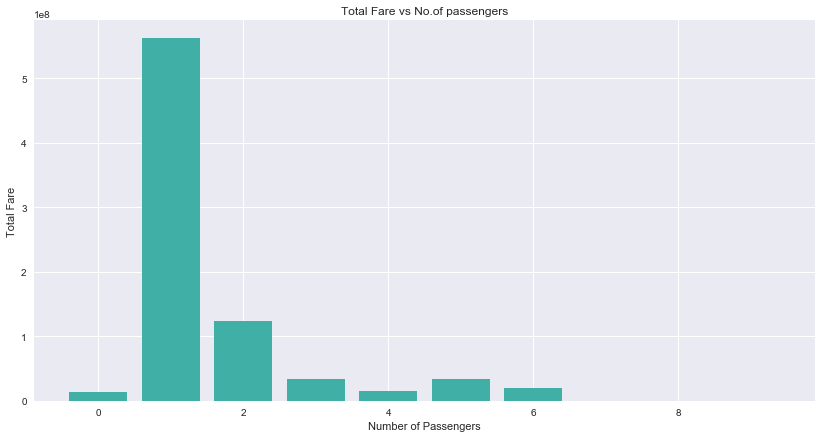

In [35]:
df_pc = pd.read_sql_query('SELECT passenger_count, SUM(total_amount) AS total, count(*) AS PCount FROM nyc_records GROUP BY passenger_count', engine)

plt.figure(figsize=(14, 7))
plt.bar(df_pc['passenger_count'], df_pc['total'], color='#40B0A6')
plt.xlabel("Number of Passengers")
plt.ylabel("Total Fare")
plt.title("Total Fare vs No.of passengers")
plt.show()

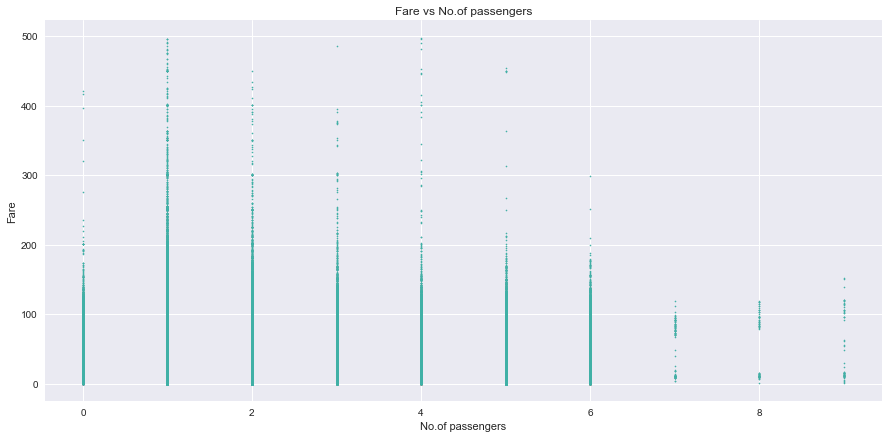

In [28]:
plt.figure(figsize=(15,7))
plt.scatter(x=df['passenger_count'], y=df['total_amount'], s=1.5, color="#40B0A6")
plt.title("Fare vs No.of passengers")
plt.xlabel('No.of passengers')
plt.ylabel('Fare')
plt.show()

- As seen from the above plots, we can see that single passengers are the most frequent travellers followed by two passenger and thus yellow taxis profits from cabs that carry just 1 passenger. This is intersting, there are lot of variations in fare based on no.of passengers.

#### Does the hour of the day affect the fare?
This question helps in understanding the demand of yellow taxis on hourly basis. We will use pickup hour

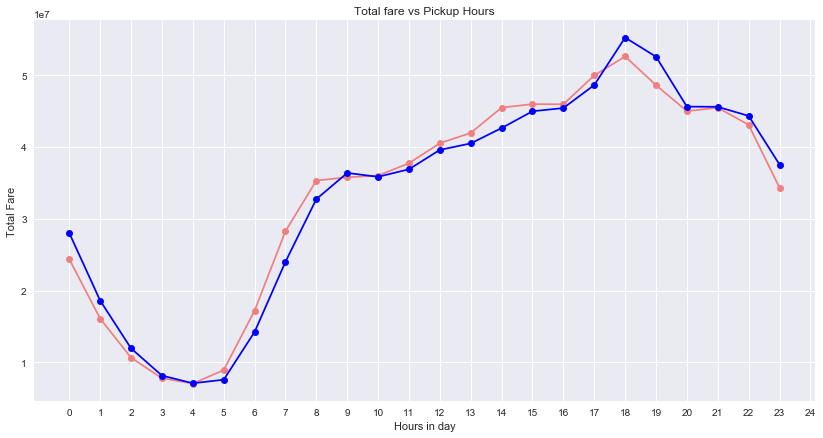

In [20]:
df_ph = pd.read_sql_query('SELECT pickup_hour, SUM(total_amount) AS total, count(pickup_hour) AS phcount FROM nyc_records \
                                GROUP BY pickup_hour', engine)
df_dh = pd.read_sql_query('SELECT dropoff_hour, SUM(total_amount) AS total, count(dropoff_hour) AS phcount FROM nyc_records \
                                GROUP BY dropoff_hour', engine)

hr = np.arange(0,25,1)
plt.figure(figsize=(14, 7))
plt.plot(df_ph['pickup_hour'], df_ph['total'], color='#F08080', linestyle='-', marker='o')
plt.plot(df_dh['dropoff_hour'], df_dh['total'], color='b', linestyle='-', marker='o')
plt.xticks(hr)
plt.xlabel("Hours in day")
plt.ylabel("Total Fare")
plt.title("Total fare vs Pickup Hours")
plt.show()

This is interesting! Time of the day definetly play an important role! The demand of taxis increases during evening hours. The fare seems to be increasing from **5 AM** to **9 AM** and from **4 PM** to **6 PM**. However, we see that for both pickup_hours and dropoff_hours the plot is almost the same. Hence, we will use only the pickup_hours for our analysis to avoid redundancy.

#### Does the day of the week affect the fare?
As lot of passengers travel via taxi, this question will help to understand the demand, yellow taxis have on a daily basis.

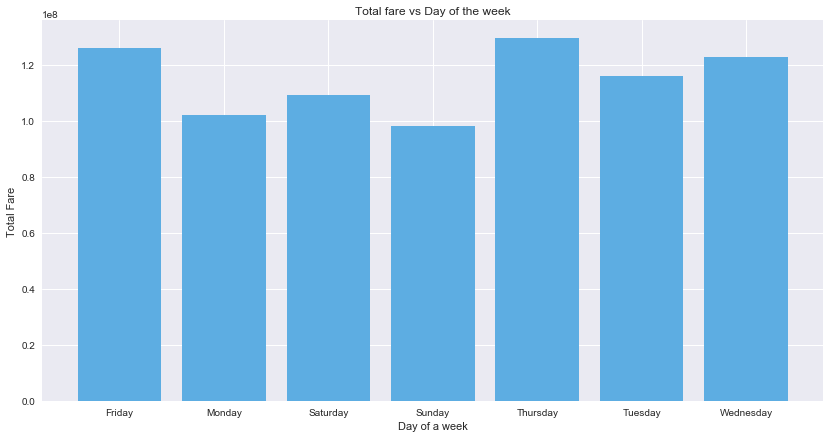

In [22]:
df_day = pd.read_sql_query('SELECT weekday, SUM(total_amount) AS total, count(weekday) AS wcount FROM nyc_records \
                                GROUP BY weekday', engine)

plt.figure(figsize=(14, 7))
plt.bar(df_day['weekday'], df_day['total'], color='#5DADE2')
plt.xlabel("Day of a week")
plt.ylabel("Total Fare")
plt.title("Total fare vs Day of the week")
plt.show()

- People travel most on Friday and Thurday and least on Monday and Sunday.

#### Change in fare_amount based on Day of the week and Hours 

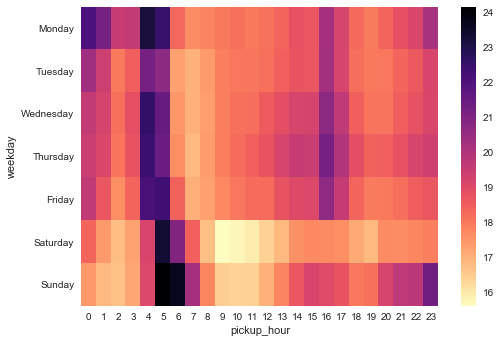

In [24]:
tc = df.pivot_table(index='weekday', columns='pickup_hour', values='total_amount')
k = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tc = tc.reindex(index=k)
heat_map = sns.heatmap(data = tc, cmap="magma_r")
var = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

Heatmap is an interesting way to visualize the data. The above plotted heatmap shows the reltion between Hours, weekdays and taxi fare.

#### Does payment types has any effect  on fare?
I'm sure most of the payment is done using debit/credit cards, however, it always wise to explore the data as you never know what hidden information is lying in the data.

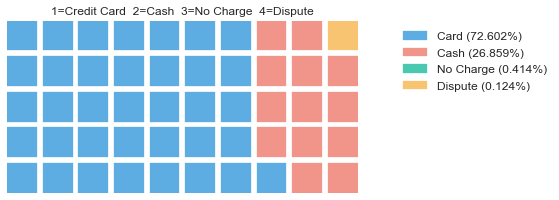

In [41]:
from pywaffle import Waffle

df_pt = pd.read_sql_query('SELECT payment_type, SUM(total_amount) AS total, count(payment_type) AS PTCount FROM \
                                  nyc_records WHERE payment_type BETWEEN 1 AND 4 GROUP BY payment_type', engine)

# Converting the counts into percentage for the convenience of interpreting
ls = np.array([df_pt['PTCount'][0], df_pt['PTCount'][1], df_pt['PTCount'][2], df_pt['PTCount'][3]])
total = np.sum(ls)
ls = ls/total
ls = np.round(ls * 100, 3)

data = {'Card': ls[0], 'Cash': ls[1], 'No Charge': ls[2], 'Dispute': ls[3]}
plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=[df_pt['PTCount'][0], df_pt['PTCount'][1], df_pt['PTCount'][2], df_pt['PTCount'][3]],
    colors=["#5DADE2", "#F1948A", "#48C9B0", "#F8C471"],
    title={
        'label': 'Example plot', 'loc': 'center',
        'fontdict': {'fontsize': 20} },
    labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={ 'loc': 'upper left', 'bbox_to_anchor': (1.1, 1), 'fontsize': 12 },
    rounding_rule='floor'
)
plt.title("1=Credit Card  2=Cash  3=No Charge  4=Dispute")
plt.show()

Payement method doesn't seem to have that much of an influence on the number of cab rides as most of the payment is done through cards.

#### Does trip distance has any effect  on fare?

In [38]:
bins_0 = df.loc[(df['trip_distance'] == 0), ['trip_distance']]
bins_1 = df.loc[(df['trip_distance'] > 0) & (df['trip_distance'] <= 5),['trip_distance']]
bins_2 = df.loc[(df['trip_distance'] > 5) & (df['trip_distance'] <= 10),['trip_distance']]
bins_3 = df.loc[(df['trip_distance'] > 10) & (df['trip_distance'] <= 20),['trip_distance']]
bins_4 = df.loc[(df['trip_distance'] > 20) & (df['trip_distance'] <= 30),['trip_distance']]
bins_5 = df.loc[(df['trip_distance'] > 30) & (df['trip_distance'] <= 50),['trip_distance']]
bins_6 = df.loc[(df['trip_distance'] > 50),['trip_distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-5'
bins_2['bins'] = '6-10'
bins_3['bins'] = '11-20'
bins_4['bins'] = '21-30'
bins_5['bins'] = '31-50'
bins_6['bins'] = '>50'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
print(len(dist_bins))
# dist_bins.head(10)

43720476


In [39]:
test = dist_bins.groupby('bins').count()
xt = ['0','0-5','6-10','11-20','21-30','31-50','>50']

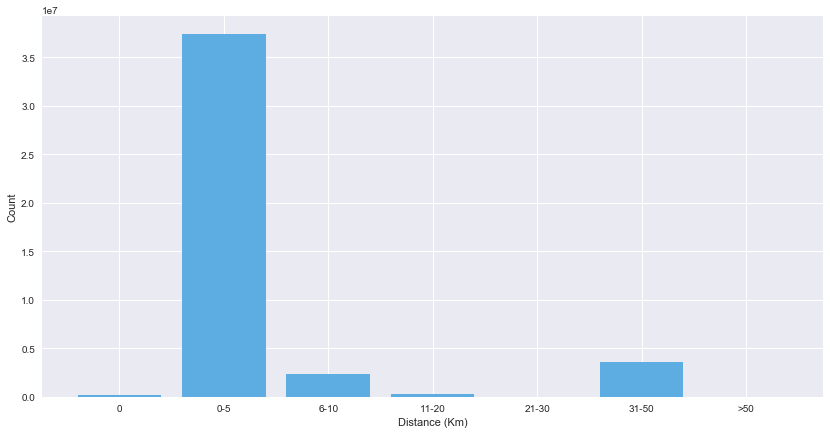

In [40]:
plt.figure(figsize=(14, 7))
plt.bar(xt, test['trip_distance'], color='#5DADE2')
plt.xlabel("Distance (Km)")
plt.ylabel("Count")
plt.show()

As we can see most of the trips are for 0 to 5 km. Since trip distance determines the fare we should keep it in our analysis.

#### How does fare changes based on pickup and dropoffs at a particular Borough

We have a **boroughs** column. New York City is composed of five boroughs: The Bronx, Brooklyn, Manhattan, Queens, and Staten Island. Let us see how are the fares for each of the boroughs.

Text(0, 0.5, 'Fare')

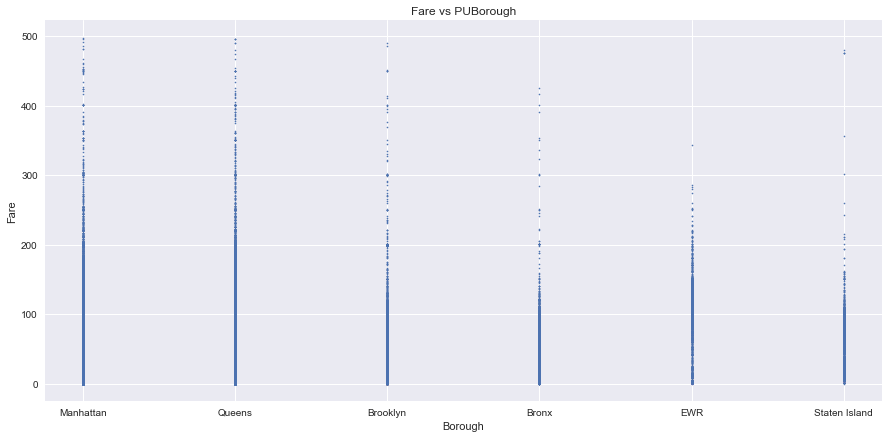

In [17]:
plt.figure(figsize=(15,7))
plt.scatter(x=df['PUBorough'], y=df['total_amount'], s=1.5)
plt.title("Fare vs PUBorough")
plt.xlabel('Borough')
plt.ylabel('Fare')

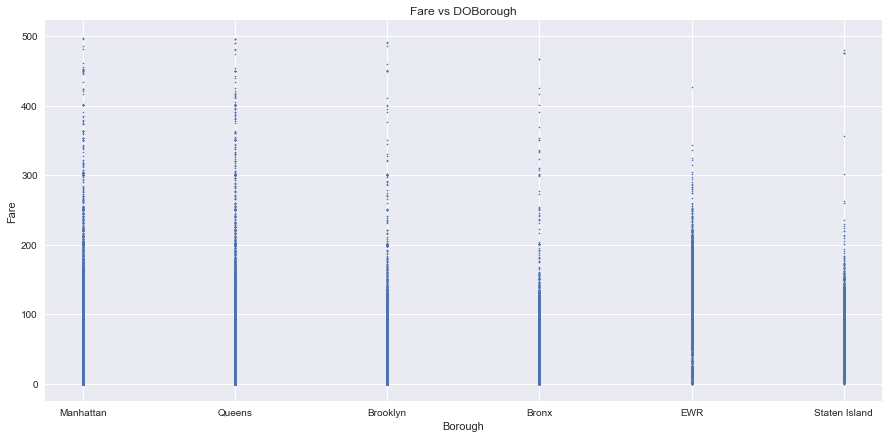

In [23]:
plt.figure(figsize=(15,7))
plt.scatter(x=df['DOBorough'], y=df['total_amount'], s=1.5)
plt.title("Fare vs DOBorough")
plt.xlabel('Borough')
plt.ylabel('Fare')
plt.show()

Both the plots looks almost the same. We will use just PULocationID as we don't want to use redudant variables.

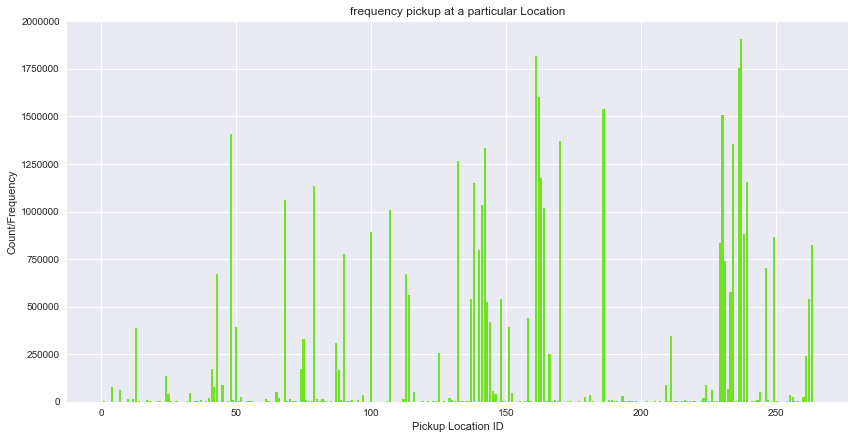

In [29]:
df_pid = pd.read_sql_query('SELECT PULocationID, count(PULocationID) AS PIDcount FROM nyc_records \
                                GROUP BY PULocationID', engine)

plt.figure(figsize=(14, 7))
plt.bar(df_pid['PULocationID'], df_pid['PIDcount'], color='#70E424')
plt.xlabel("Pickup Location ID")
plt.ylabel("Count/Frequency")
plt.title("frequency pickup at a particular Location")
plt.show()

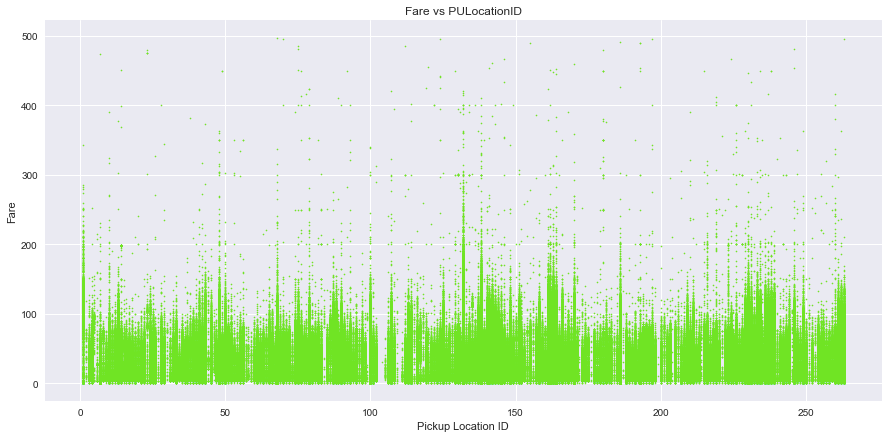

In [30]:
plt.figure(figsize=(15,7))
plt.scatter(x=df['PULocationID'], y=df['total_amount'], s=1.5, color='#70E424')
plt.title("Fare vs PULocationID")
plt.xlabel('Pickup Location ID')
plt.ylabel('Fare')
plt.show()

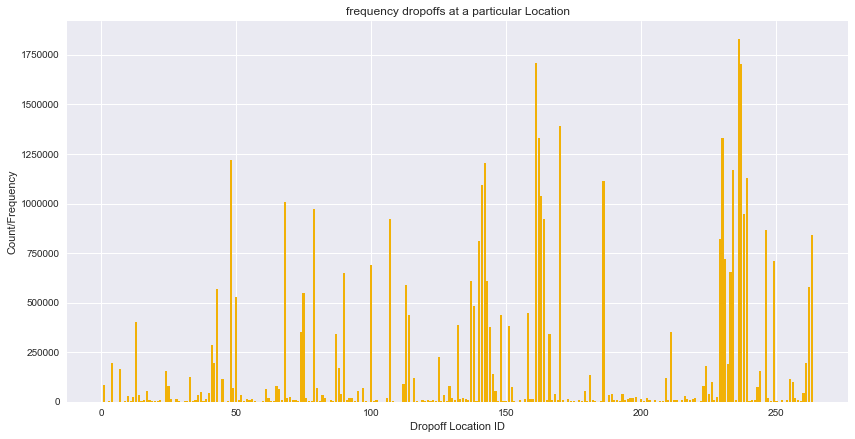

In [31]:
df_did = pd.read_sql_query('SELECT DOLocationID, count(DOLocationID) AS DIDcount FROM nyc_records \
                                GROUP BY DOLocationID', engine)

plt.figure(figsize=(14, 7))
plt.bar(df_did['DOLocationID'], df_did['DIDcount'], color='#F1B107')
plt.xlabel("Dropoff Location ID")
plt.ylabel("Count/Frequency")
plt.title("frequency dropoffs at a particular Location")
plt.show()

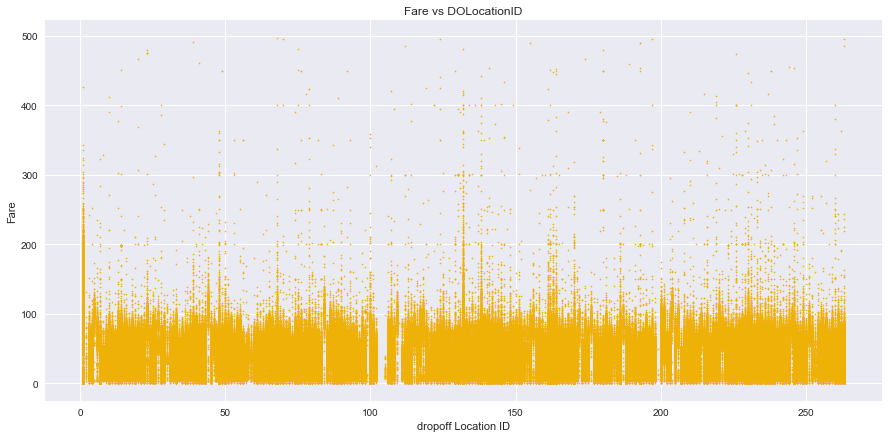

In [32]:
plt.figure(figsize=(15,7))
plt.scatter(x=df['DOLocationID'], y=df['total_amount'], s=1.5, color='#F1B107')
plt.title("Fare vs DOLocationID")
plt.xlabel('dropoff Location ID')
plt.ylabel('Fare')
plt.show()

#### How is the distribution of the total fare?
We look at the distribution of the total_amount, the target variables we want to train a model to predict.

Text(0.5, 0, 'Total fare')

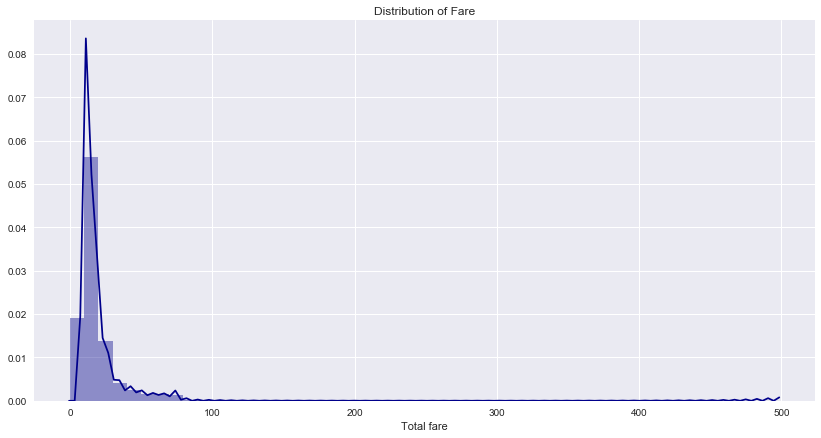

In [38]:
plt.figure(figsize=(14, 7))
sns.distplot(df['total_amount'], color = 'darkblue');
plt.title('Distribution of Fare');
plt.xlabel("Total fare")

It can be seen from the above plot that both the data is right skewed. Thus we apply transformation on the data. Most commonly used transformation is **Log transformation**.

In [16]:
df['log_total_amount'] = np.log1p(df['total_amount'])

Text(0.5, 0, 'loig(Total fare)')

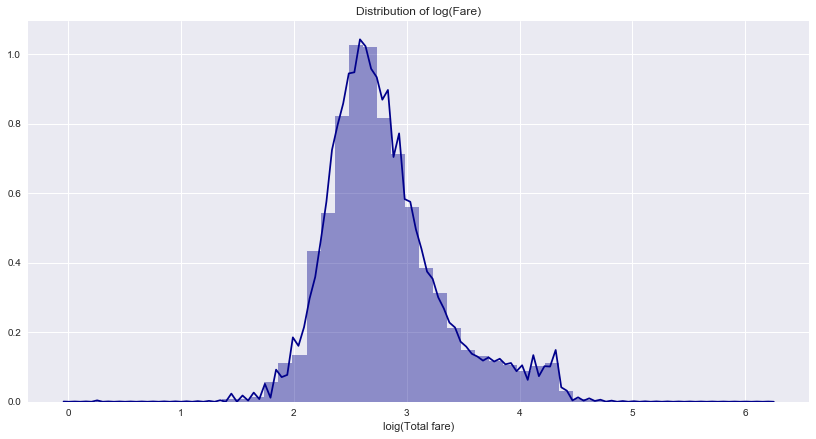

In [40]:
plt.figure(figsize=(14, 7))
sns.distplot(df['log_total_amount'], color='darkblue');
plt.title('Distribution of log(Fare)');
plt.xlabel("loig(Total fare)")

## Predictive Analysis
Here we are going to use gradient boosting method: XGBoost along with gridSearchCV for parameter selection. Let's select the predictors from features, since we should not consider all features for training our model. However, Before we move on, we have to convert Weekday and PUBorough into numeric form.

In [17]:
df['weekday'] = df['weekday'].astype('category')
df['weekday'] = df['weekday'].cat.codes

df['PUBorough'] = df['PUBorough'].astype('category')
df['PUBorough'] = df['PUBorough'].cat.codes

In [18]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,weekday,pickup_hour,dropoff_hour,PUBorough,DOBorough,log_total_amount
0,2019-03-12 10:36:53,2019-03-12 10:49:17,1,1.40,1,237,161,1,2.46,14.76,5,10,10,3,Manhattan,2.757475
1,2019-03-12 16:17:56,2019-03-12 16:45:18,2,3.90,1,261,234,1,2.00,25.80,5,16,16,3,Manhattan,3.288402
2,2019-03-12 18:04:12,2019-03-12 18:24:22,2,1.25,1,230,141,1,3.46,20.76,5,18,18,3,Manhattan,3.080073
3,2019-03-12 13:24:25,2019-03-12 13:35:43,1,1.45,1,114,234,2,0.00,12.30,5,13,13,3,Manhattan,2.587764
4,2019-03-12 12:42:55,2019-03-12 12:50:46,1,1.53,1,143,48,1,1.00,11.80,5,12,12,3,Manhattan,2.549445


Now before we move ahead and split the data into train-test sets, it is important to know that we need to shuffle the dataframe. our data is in temporal order, and spliting the data without shuffling might cause the machine learning model to learn dependencies amongst the data resulting in poor performance. Hence, when we first create the master dataframe, we random shuffled both the dataframe before appending to the list and the list itself once all the chunck dataframes had been appended.

In [19]:
selected_predictors = ['pickup_hour', 'passenger_count', 'trip_distance', 'weekday', 'PUBorough', 'PULocationID']
df_X = df[selected_predictors]
print(len(df_X))
df_X.head()

43720476


,pickup_hour,passenger_count,trip_distance,weekday,PUBorough,PULocationID
0,10,1,1.40,5,3,237
1,16,2,3.90,5,3,261
2,18,2,1.25,5,3,230
3,13,1,1.45,5,3,114
4,12,1,1.53,5,3,143


In [20]:
df_Y = df[['log_total_amount']]
print(len(df_Y))
df_Y.head()

43720476


,log_total_amount
0,2.757475
1,3.288402
2,3.080073
3,2.587764
4,2.549445


#### XGBoost

In [21]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

In [22]:
X = df_X.loc[:, selected_predictors].values
y = df_Y.log_total_amount.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/20)

In [23]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

41534452
2186024
41534452
2186024


I'll use **GridSearchCV** with cross-validation for best parameter selection in XGBoost. We are going to provide three parameter sets **learning_rate**, **max_depth** & **n_estimators**, so that we can re-train this models with new best fit parameters. Executing the below code for finding the best parameters takes a lot of time and hence, I'll use oly first 1000000 records

In [32]:
parameters = {
                'learning_rate': [0.3, 0.1, 0.5],
                'max_depth': [4, 5, 6, 7, 8],
                'n_estimators': [300, 400, 450, 500]
            }

XGB_hyper_params = GridSearchCV(estimator=XGBRegressor(objective ='reg:squarederror'), param_grid=parameters, n_jobs=-1, cv=5)

In [33]:
XGB_hyper_params.fit(X_train[:500000], y_train[:500000])
# find out the best hyper parameters
XGB_hyper_params.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}

In [24]:
XGB_model = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=400)
XGB_model.fit(X_train, y_train)
y_XGB_predict = XGB_model.predict(X_test)

XGB_model_error = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_XGB_predict)))

print(f'XGBoost Mean Squared Error: {XGB_model_error}')

[02:59:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
XGBoost Mean Squared Error: 5.072769370465672
